In [11]:
!pip install wordcloud

     |████████████████████████████████| 220 kB 4.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158793 sha256=2e64ff8828d52f878bb82e11be0cb45abc5320e4b41f9ef156e355886561d84e
  Stored in directory: /Users/yuzhang/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import re
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('downloads/data'):
    for filename in filename:
        print(os.path.join(dirname, filename))

In [19]:
test = pd.read_csv('/Users/yuzhang/Downloads/data/test.csv')
train = pd.read_csv('/Users/yuzhang/Downloads/data/train.csv')

concat_df = pd.concat([test, train], ignore_index = True)
concat_df = concat_df.sample(frac=1)

#### Exploratory Data Analysis

In [20]:
concat_df

,id,keyword,location,text,target
8669,7717,panicking,NaN,People are finally panicking about cable TV ht...,0.0
7545,6085,hellfire,Rheinbach / Germany,Orchid - Sign Of The Witch http://t.co/YtkXwPyIHg,0.0
3672,589,arson,NaN,Tennessee lesbian couple faked hate crime and ...,1.0
5385,3049,death,?s????ss? a?????,Ari's hints and snippets will be the death of me.,0.0
9042,8246,rioting,SURROUNDED BY WEEABOOS,'Money can't buy happiness' is just a lie we t...,1.0
...,...,...,...,...,...
8989,8171,rescuers,NaN,http://t.co/XlFi7ovhFJ VIDEO: 'We're picking u...,1.0
5436,3116,debris,NaN,RÌ©union Debris Is Almost Surely From Flight 3...,1.0
2145,7182,mudslide,St Albans,@curryspcworld looks like a mudslide. Unreal s...,NaN
5529,3248,deluged,Pakistan,News Alerts - Glimpses: Hyderabad deluged by h...,1.0


In [21]:
concat_df.sample(5)

,id,keyword,location,text,target
9305,8637,seismic,UK,ENGLAND EAST COAST. Dogger Bank Westward. 1. S...,0.0
785,2584,crash,Highway to Hell,Time to enjoy summer in a crash course of two ...,NaN
3882,892,bioterrorism,"Netherlands,Amsterdam-Virtual",In Lies We Trust #dvd CIA Hollywood and Bioter...,0.0
936,3088,deaths,"Georgetown,Guyana",Infections driving up neonatal deaths ÛÒ Heal...,NaN
1834,6194,hijacker,NaN,Governor allows parole for California school b...,NaN


In [22]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 8669 to 727
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 509.8+ KB


In [23]:
concat_df.describe()

,id,target
count,10876.000000,7613.00000
mean,5437.500000,0.42966
std,3139.775098,0.49506
min,0.000000,0.00000
25%,2718.750000,0.00000
50%,5437.500000,0.00000
75%,8156.250000,1.00000
max,10875.000000,1.00000


In [24]:
concat_df.duplicated().sum()

0

In [29]:
#### NUll Values Count

null = pd.DataFrame({'null':concat_df.isna().sum(), 'pct_null':round(concat_df.isna().sum() / len(concat_df), 5) * 100})
null = null.sort_values('pct_null', ascending = False)
null

,null,pct_null
location,3638,33.450
target,3263,30.002
keyword,87,0.800
id,0,0.000
text,0,0.000


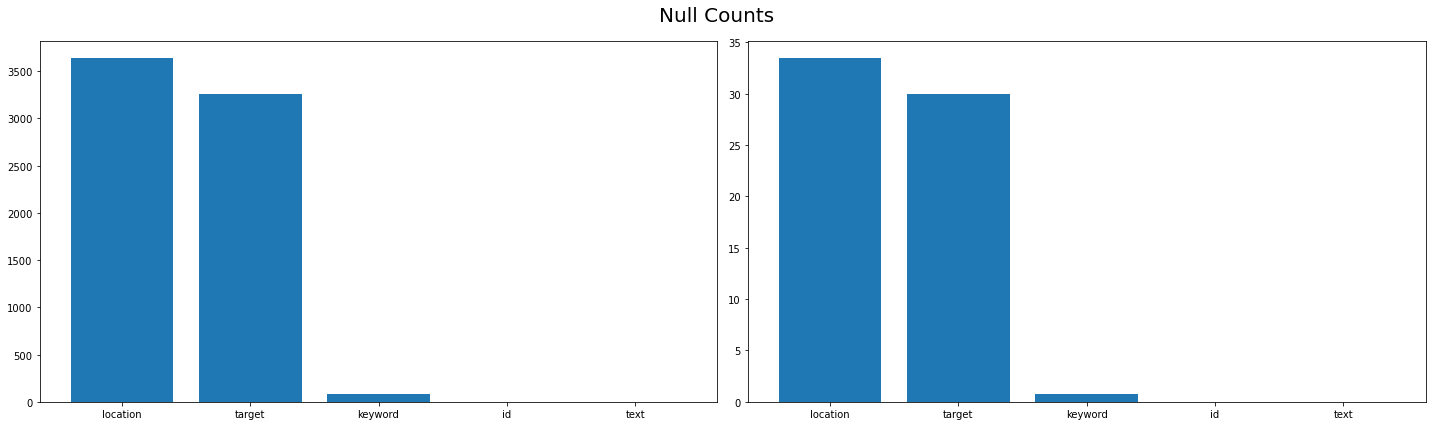

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(20, 6))
plt.suptitle('Null Counts', fontsize=20)

ax1.bar(null.index, null.null)
ax2.bar(null.index, null.pct_null)

plt.tight_layout()
plt.show()

#### Target distribution

In [32]:
targets = ['0.0', '1.0', 'null']
target_count = [i for i in concat_df.target.value_counts()]
target_count.append(concat_df.target.isna().sum())

target_count

[4342, 3271, 3263]

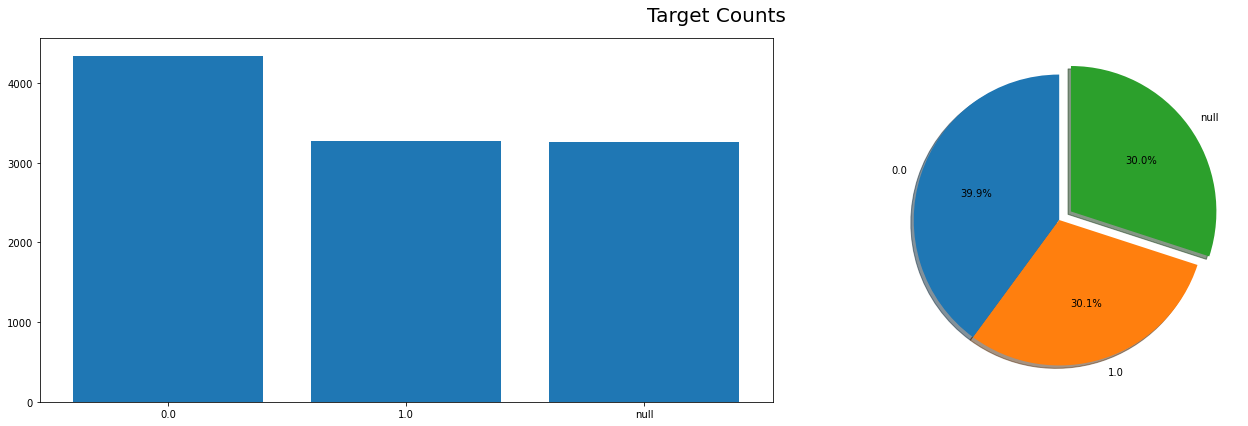

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows=1, figsize = (20, 6))
plt.suptitle('Target Counts', fontsize= 20)

ax1.bar(targets, target_count)
ax2.pie(target_count, labels=targets, explode=[0.0, 0.0, 0.1], startangle=90, shadow=True, autopct='%1.1f%%')

plt.tight_layout()
plt.show()

#### Feature Engineering

In [38]:
class FE:
    def __init__(self, df):
        self.df = df
        
    def add_column(self):
        column = Column(self.df)
        column.add_all()
        
class Column(FE):
    
    def __init__(self, df):
        super().__init__(df)
    
    def add_len(self):
        self.df['text_len']=self.df.text.apply(lambda x:len(x))
        
    def add_tags(self):
        regex = 'x(\w+)'
        for index, text in enumerate(self.df.text):
            tags = re.findall(regex, text)
            if len(tags) ==0:
                self.df.loc[index, 'hashtags']=None
                self.df.loc[index, 'hashtags_count']=0
            else:
                self.df.loc[index, 'hashtags']=', '.join(tags)
                self.df.loc[index, 'hashtags_count']=len(tags)
                
    def add_mention(self):
        regex = '@(\w+)'
        for index, text in enumerate(self.df.text):
            mention = re.findall(regex, text)
            if len(mention) ==0:
                self.df.loc[index, 'mention']=None
                self.df.loc[index, 'mention_count']=0
            else:
                self.df.loc[index, 'mention'] =', '.join(mention)
                self.df.loc[index, 'mention_count']=len(mention)
                
    def add_clean_text(self):
        for index, text in enumerate(self.df.text):
            clean_text = re.sub(r'http\S+', '', text)
            clean_text = re.sub(r'[^A-Za-z0-9]+',' ', clean_text)
            clean_text = re.sub(r'@(\w+)',' ', clean_text)
            clean_text = re.sub(r'\w*\d\w*',' ', clean_text)
            clean_text = clean_text.strip()
            clean_text = re.sub("\s\s+", " ", clean_text)
            self.df.loc[index, 'clean_text']=clean_text.lower()
            
    def add_has_location(self):
        for index, location in enumerate(self.df.location):
            if isinstance(location, str):
                self.df.loc[index, 'has_location']=1
            else:
                self.df.loc[index, 'has_location']=0
                
    def add_has_key(self):
        for index, location in enumerate(self.df.keyword):
            if isinstance(location, str):
                self.df.loc[index, 'has_key']=1
            else:
                self.df.loc[index, 'has_key']=0
    
    def add_all(self):
        self.add_len()
        self.add_tags()
        self.add_mention()
        self.add_clean_text()
        self.add_has_location()
        self.add_has_key()
        
        return self.df

In [39]:
fe = FE(train)
fe.add_column()

fe = FE(test)
fe.add_column()

## Data visualization

<AxesSubplot:xlabel='text_len', ylabel='Count'>

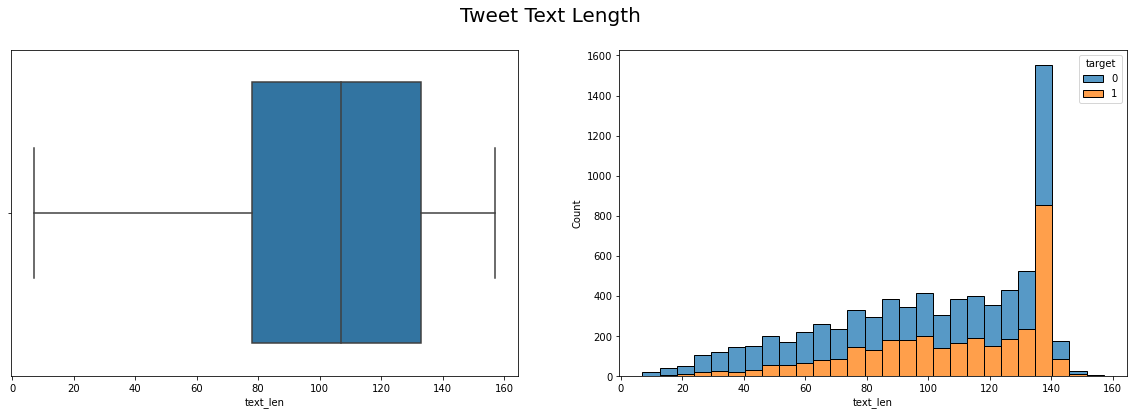

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,6))

plt.suptitle('Tweet Text Length', fontsize = 20)
sns.boxplot(ax = ax1, data = train, x = 'text_len')
sns.histplot(ax=ax2, data = train, x = 'text_len', hue = 'target', multiple = 'stack')

In [41]:
train = train[['id', 'keyword', 'location', 'has_key', 'has_location', 'hashtags', 'hashtags_count',
              'mention', 'mention_count', 'text_len', 'target', 'text', 'clean_text']]

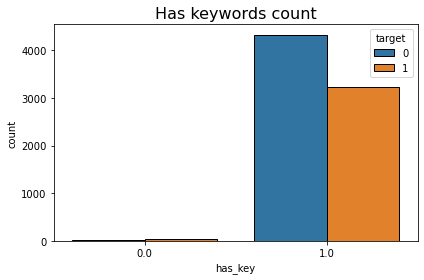

In [42]:
sns.countplot(data=train, x ='has_key', hue= 'target', edgecolor='black')
plt.title('Has keywords count', fontsize=16)
plt.tight_layout()

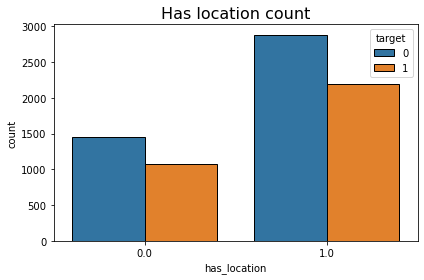

In [43]:
sns.countplot(data=train, x = 'has_location', hue='target', edgecolor='black')
plt.title('Has location count', fontsize = 16)
plt.tight_layout()

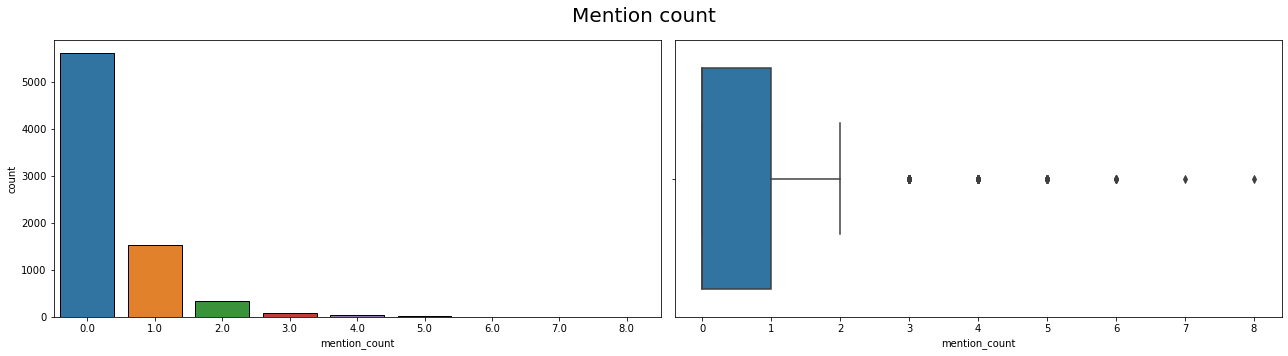

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 5))
plt.suptitle('Mention count', fontsize = 20)

sns.countplot(ax = ax1, data=train, x = 'mention_count', edgecolor = 'black')
sns.boxplot(ax = ax2, data = train, x = 'mention_count')

plt.tight_layout()

In [47]:
top5_keys = train.keyword.value_counts()[:50].index.tolist()
top5_count = train.keyword.value_counts()[:50].tolist()

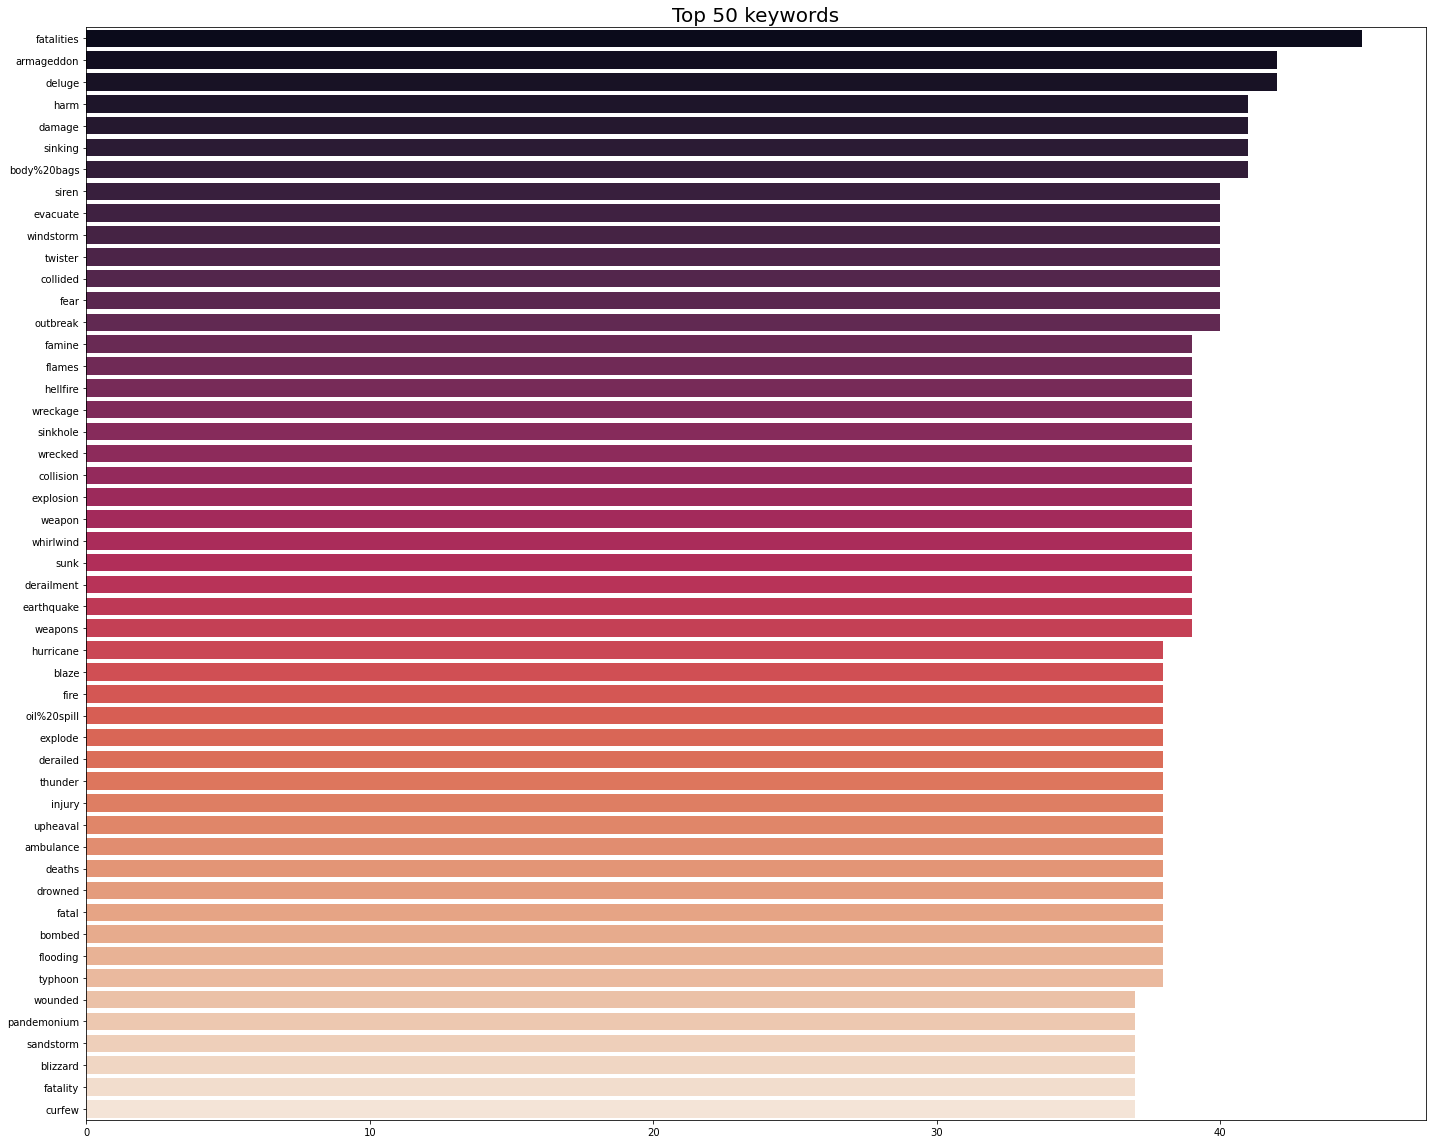

In [48]:
plt.figure(figsize=(20,16))
plt.title('Top 50 keywords', fontsize = 20)

sns.barplot(x=top5_count, y=top5_keys, palette='rocket')

plt.tight_layout()

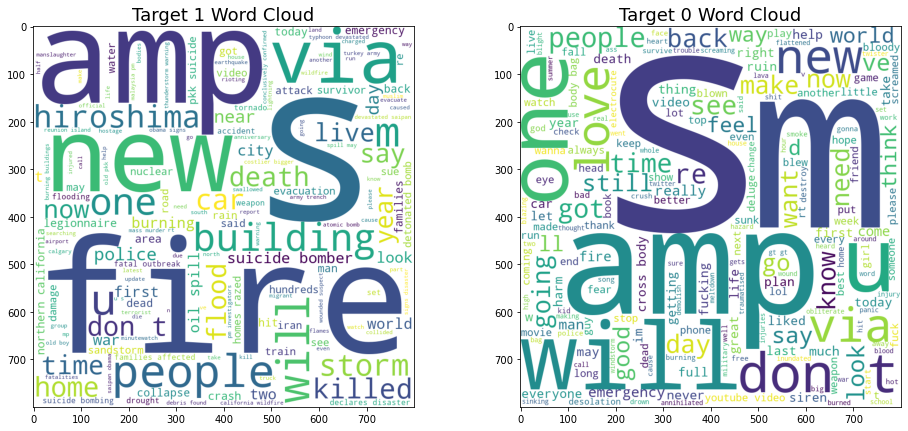

In [53]:
target1_words = ''
target0_words = ''

stopwords = set(STOPWORDS)

for i in train[train.target == 1.0].clean_text:
    target1_words += i
    
for i in train[train.target ==0.0].clean_text:
    target0_words += i 
    
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16,7))

wordcloud1 = WordCloud(width=800, height=800, 
                      background_color = 'white', 
                      stopwords = stopwords, 
                      min_font_size = 10).generate(target1_words)

wordcloud0 = WordCloud(width= 800, height = 800,
                      background_color = 'white', 
                      stopwords = stopwords,
                      min_font_size = 10).generate(target0_words)

ax1.imshow(wordcloud1)
ax1.set_title('Target 1 Word Cloud', fontsize=18)

ax2.imshow(wordcloud0)
ax2.set_title('Target 0 Word Cloud', fontsize = 18)

plt.show()

#### Data Processing

In [54]:
print(train.target.value_counts())

0    4342
1    3271
Name: target, dtype: int64


In [55]:
class Data:
    def __init__(self, data):
        self.data = data
        
    def fix(self):
        minmum = min(train.target.value_counts().tolist())
        
        fixed_data = pd.concat([self.data[self.data.target ==1.0][:minmum],
                               self.data[self.data.target ==0.0][:minmum]])
        
        fixed_data = fixed_data.sample(frac = 1).reset_index()
        return fixed_data

#### Train Test Split

In [58]:
X = train.clean_text
y = train.target

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state=1)

#### Vectorize Text

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

train_x_vectors = vectorizer.fit_transform(train_X)
test_x_vectors = vectorizer.transform(test_x)

#### Creating Models

In [60]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [67]:
class Model:
    def __init__(self, model):
        self.model=model
    
    def predict(self):
        self.model.fit(train_x_vectors, train_y)
        model_pred = self.model.predict(test_x_vectors)
        self.get_score(model_pred)
        
    def get_score(self, model_pred):
        model_acc = accuracy_score(model_pred, test_y)
        model_report = classification_report(model_pred, test_y)
        model_f1 = f1_score(model_pred, test_y)
        model_cv = cross_val_score(self.model, train_x_vectors, train_y, cv = 5)
        
        print(f'Accuracy Score:{model_acc}\mMean Cross Validation:{np.mean(model_cv)}\n\n{model_report}\nf1_score:{model_f1}')

#### Linear SVC

In [68]:
from sklearn.svm import LinearSVC
model = Model(LinearSVC())
model.predict()

Accuracy Score:0.7778361344537815\mMean Cross Validation:0.7812231873291472

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1172
           1       0.69      0.77      0.73       732

    accuracy                           0.78      1904
   macro avg       0.77      0.78      0.77      1904
weighted avg       0.78      0.78      0.78      1904

f1_score:0.7262135922330097


#### Support Vector Machine

In [69]:
from sklearn.svm import SVC
model = Model(SVC())
model.predict()

Accuracy Score:0.803046218487395\mMean Cross Validation:0.7922590716043167

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1312
           1       0.63      0.87      0.73       592

    accuracy                           0.80      1904
   macro avg       0.78      0.82      0.79      1904
weighted avg       0.84      0.80      0.81      1904

f1_score:0.7330960854092526


#### Random Forest Classification

In [76]:
from sklearn.ensemble import RandomForestClassifier
model = Model(RandomForestClassifier())
model.predict()

Accuracy Score:0.7941176470588235\mMean Cross Validation:0.7901556535499784

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1315
           1       0.62      0.86      0.72       589

    accuracy                           0.79      1904
   macro avg       0.77      0.81      0.78      1904
weighted avg       0.83      0.79      0.80      1904

f1_score:0.7203994293865906


#### Decision Tree Classifer

In [78]:
from sklearn.tree import DecisionTreeClassifier
model = Model(DecisionTreeClassifier())
model.predict

<bound method Model.predict of <__main__.Model object at 0x7fc951b09040>>

#### KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier
model = Model(KNeighborsClassifier())
model.predict()

Accuracy Score:0.6853991596638656\mMean Cross Validation:0.6712201328910794

              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1598
           1       0.32      0.85      0.46       306

    accuracy                           0.69      1904
   macro avg       0.64      0.75      0.62      1904
weighted avg       0.86      0.69      0.73      1904

f1_score:0.46470062555853436


#### Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression
model = Model(LogisticRegression())
model.predict()

Accuracy Score:0.7977941176470589\mMean Cross Validation:0.7982155328152556

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1204
           1       0.69      0.81      0.75       700

    accuracy                           0.80      1904
   macro avg       0.78      0.80      0.79      1904
weighted avg       0.81      0.80      0.80      1904

f1_score:0.745538664904164


#### Naive Bayesian

In [85]:
from sklearn.naive_bayes import MultinomialNB
model = Model(MultinomialNB())
model.predict()

Accuracy Score:0.8061974789915967\mMean Cross Validation:0.793661350307209

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1210
           1       0.70      0.82      0.76       694

    accuracy                           0.81      1904
   macro avg       0.79      0.81      0.80      1904
weighted avg       0.82      0.81      0.81      1904

f1_score:0.7551426675514266


#### Hyperparameter Tuning

In [95]:
model = LogisticRegression()
params = {
    'solver':['newton-cg', 'lbfgs', 'liblinear'],
    'penalty':['l2'],
    'C':[100, 10, 1.0, 0.1, 0.01]
}

logistic = GridSearchCV(estimator=model, param_grid=params, cv=5)

logistic.fit(train_x_vectors, train_y)
logistic_pred = logistic.predict(test_x_vectors)

score = pd.DataFrame(logistic.cv_results_)

In [96]:
print(f'Accuracy Score :{accuracy_score(logistic_pred, test_y)}')

Accuracy Score :0.7972689075630253


In [97]:
score[['param_solver', 'param_C', 'param_penalty', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

,param_solver,param_C,param_penalty,mean_test_score
8,liblinear,1.0,l2,0.798391
11,liblinear,0.1,l2,0.798390
6,newton-cg,1.0,l2,0.798216
7,lbfgs,1.0,l2,0.798216
9,newton-cg,0.1,l2,0.798040
10,lbfgs,0.1,l2,0.798040
4,lbfgs,10,l2,0.791033
3,newton-cg,10,l2,0.790858
5,liblinear,10,l2,0.790858
2,liblinear,100,l2,0.782799


#### Submit Results

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()

train_vec = vec.fit_transform(train.clean_text)
test_vec = vec.transform(test.clean_text)

In [102]:
final_model = LogisticRegression()
final_model.fit(train_vec, train.target)

model_pred = final_model.predict(test_vec)

In [109]:
output = pd.read_csv('/Users/yuzhang/Downloads/submission/sample_submission.csv')

output['target'] = model_pred

output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
